In [1]:
#graphs and utilities
import pandas as pd #pandas stands for panel data
import numpy as np
import math as ma
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

#Analysis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from scipy.stats.stats import pearsonr

#regression models
from scipy.stats import linregress as linRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor

#model metrics, deciding which models perform best
from sklearn.metrics import mean_squared_error, r2_score

df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

all_dfs = [df_train,df_test]

def makeDict(df,label):
    strcat_dict = {}
    for i,row in df.iterrows():
        strcat_dict[row[label]] = i 
    return strcat_dict

def makeOrdinal(df,label,showDict):
    filtered = df.sort_values([label], ascending = [True])
    df_filtered = filtered.groupby(label).first().reset_index()
    strcat_dict = {}
    
    for i,row in df_filtered.iterrows():
        strcat_dict[row[label]] = i 
    
    if showDict:
        print(strcat_dict)
    
    for j,row in df.iterrows():
        df.at[j,label] = strcat_dict.get(row[label])
    
    return df

In [2]:
quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

for column in qualitative:
    for df_single in all_dfs:
        makeOrdinal(df_single,column,False)

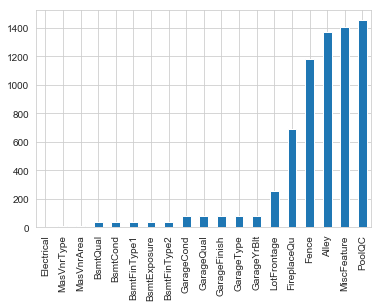

In [3]:
#quick way to see what data is missing 
sns.set_style("whitegrid")
missing = df_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

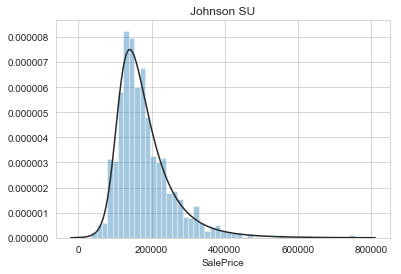

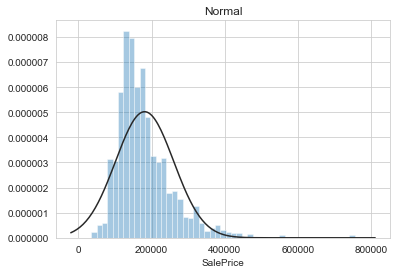

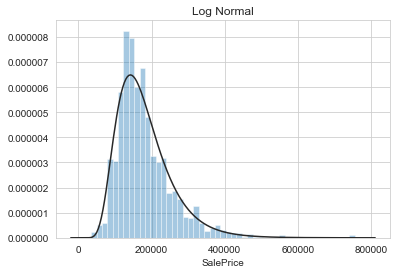

In [4]:
#distplot stands for distribution plot (so we can see how the data for SalePrice is distributed)
y = df_train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [5]:
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.05
normal = pd.DataFrame(df_train[quantitative])
normal = normal.apply(test_normality)
print(not normal.any())
#so none of the quantitiative variables are normally distrubted at a 1% significance level

False


29    EnclosedPorch
21     KitchenAbvGr
4       OverallCond
14     LowQualFinSF
33          MiscVal
9        BsmtFinSF2
35           YrSold
17     BsmtHalfBath
0        MSSubClass
32         PoolArea
30        3SsnPorch
34           MoSold
31      ScreenPorch
10        BsmtUnfSF
16     BsmtFullBath
20     BedroomAbvGr
13         2ndFlrSF
8        BsmtFinSF1
19         HalfBath
27       WoodDeckSF
1       LotFrontage
7        MasVnrArea
2           LotArea
28      OpenPorchSF
23       Fireplaces
22     TotRmsAbvGrd
6      YearRemodAdd
12         1stFlrSF
24      GarageYrBlt
11      TotalBsmtSF
18         FullBath
26       GarageArea
5         YearBuilt
25       GarageCars
15        GrLivArea
3       OverallQual
Name: feature, dtype: object


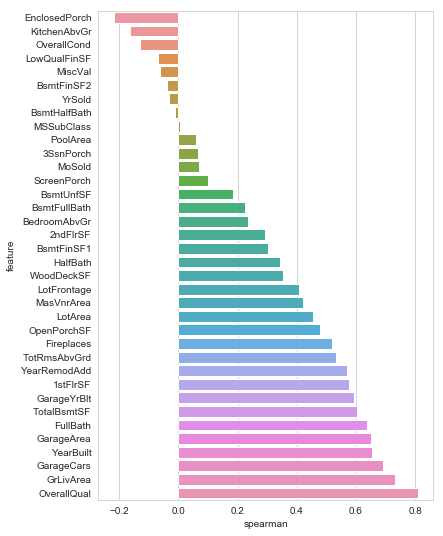

In [6]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    print(spr['feature'])
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
spearman(df_train,quantitative)

18        ExterQual
34     GarageFinish
21         BsmtQual
30      KitchenQual
38           PoolQC
27        HeatingQC
33       GarageType
0          MSZoning
3          LotShape
23     BsmtExposure
39            Fence
41         SaleType
11         BldgType
26          Heating
32      FireplaceQu
17       MasVnrType
6         LotConfig
24     BsmtFinType1
5         Utilities
4       LandContour
22         BsmtCond
1            Street
7         LandSlope
25     BsmtFinType2
10       Condition2
15      Exterior1st
16      Exterior2nd
14         RoofMatl
19        ExterCond
40      MiscFeature
31       Functional
13        RoofStyle
35       GarageQual
8      Neighborhood
9        Condition1
36       GarageCond
12       HouseStyle
37       PavedDrive
29       Electrical
28       CentralAir
42    SaleCondition
20       Foundation
2             Alley
Name: feature, dtype: object


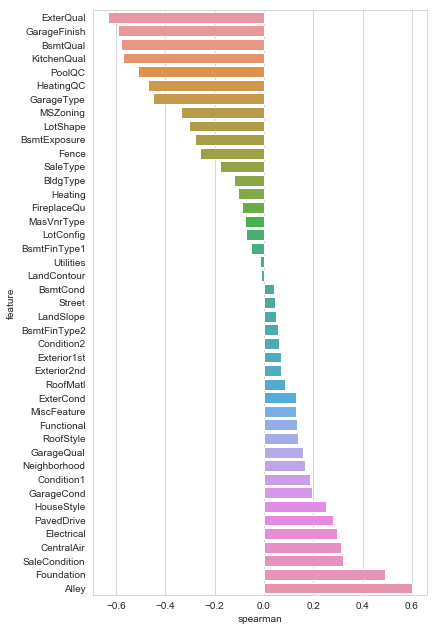

In [7]:
spearman(df_train,qualitative)

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([244.,   0., 237.,   0.,   0., 252.,   0., 256.,   0., 212.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

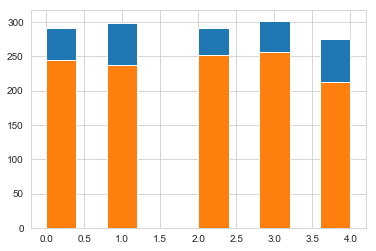

In [8]:
def bucketData(df,column_to_bucket):
    number_of_buckets = 5
    df['tempBand'] = pd.qcut(df[column_to_bucket],number_of_buckets)
    intervals = df['tempBand'].unique().sort_values().tolist()
    intervals = [x for x in intervals if str(x) != 'nan']
    
    interval_dict = {}
    for idx,interval in enumerate(intervals):
        interval_dict['low'+str(idx)] = interval.left
        interval_dict['high'+str(idx)] = interval.right
    #print(interval_dict)
    
    df.loc[ df[column_to_bucket] <= interval_dict['high0'], column_to_bucket] = 0
    df.loc[(df[column_to_bucket] > interval_dict['low1']) & \
           (df[column_to_bucket] <= interval_dict['high1']), column_to_bucket] = 1
    df.loc[(df[column_to_bucket] > interval_dict['low2']) & \
           (df[column_to_bucket] <= interval_dict['high2']), column_to_bucket] = 2
    df.loc[(df[column_to_bucket] > interval_dict['low3']) & \
           (df[column_to_bucket] <= interval_dict['high3']), column_to_bucket] = 3
    df.loc[ df[column_to_bucket] > interval_dict['low4'], column_to_bucket] = 4
    
    df = df.drop(['tempBand'], axis=1)

for df in all_dfs:
    bucketData(df,'YearBuilt')

for df in all_dfs:
    bucketData(df,'LotFrontage')
    
all_dfs = [df_train,df_test]
plt.hist(df_train['YearBuilt'])
plt.hist(df_train['LotFrontage'])

In [ ]:
#using the top 10 (positively) correlated features, based on spearman and pearson tests earlier (top var ~0.71)
#final_choices = ['1stFlrSF','FullBath','GarageArea','YearBuilt','BsmtQual_E','KitchenQual_E',\
#                'ExterQual_E','GarageCars','GrLivArea','Neighborhood_E','OverallQual','SalePrice']

final_choices = ['YearRemodAdd','1stFlrSF','GarageYrBlt','TotalBsmtSF','FullBath','GarageArea',\
                 'YearBuilt','GarageCars','GrLivArea','OverallQual','SalePrice']

best_features = df_train[final_choices]

y = best_features['SalePrice']
sale_predictors = best_features.drop(['SalePrice'], axis=1)

#only use the numerical features (when not excluding these, you will see the variation
#is spread over a greater number of Principal components, which is rubbish for us)
X = sale_predictors.select_dtypes(exclude=['object'])
#X = sale_predictors #test what happens if you don't exclude the categories
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

my_imputer = SimpleImputer(strategy='mean')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

pca_components = 7
stdscale = StandardScaler()
scaled_imputed_X_train = stdscale.fit_transform(imputed_X_train)
pca = PCA(n_components=pca_components)
pca_fin = pca.fit(scaled_imputed_X_train)
pca_fin = pca.transform(scaled_imputed_X_train)
per_var = np.round(pca.explained_variance_ratio_ * 100,decimals=1)
labelsp = ['PC' + str(x) for x in range(1,len(per_var)+1)]

print("variance of data captured: ",sum(per_var))
plt.bar(x=range(1,len(per_var)+1),height=per_var,tick_label=labelsp)
plt.xlabel("principle component")
plt.ylabel("variance explained")
plt.title("scree plot")
plt.show()

scaled_imputed_X_valid = stdscale.fit_transform(imputed_X_valid)
pca = PCA(n_components=pca_components)
pca_fin_val = pca.fit(scaled_imputed_X_valid)
pca_fin_val = pca.transform(scaled_imputed_X_valid)

In [ ]:
#fit and predict with models and measure their accuracy
#when r2 = 1, it's a perfect prediction
reg_scores = pd.DataFrame(columns=['name','mean-sq-err','variance'])
seed = 0

linear_reg = LinearRegression()
linear_reg.fit(pca_fin,y_train)
lin_reg_pred = linear_reg.predict(pca_fin_val)
reg_scores.loc[0] = ['linear regression',\
                     int(mean_squared_error(y_valid, lin_reg_pred)),r2_score(y_valid, lin_reg_pred)]

ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7),n_estimators=300, random_state=seed)
ada_reg.fit(pca_fin,y_train)
ada_reg_pred = ada_reg.predict(pca_fin_val)
reg_scores.loc[1] = ['adaboost regression',\
                     int(mean_squared_error(y_valid, ada_reg_pred)),r2_score(y_valid, ada_reg_pred)]

rf_reg = RandomForestRegressor(n_estimators=350, random_state=seed)
rf_reg.fit(pca_fin,y_train)
rf_reg_pred = rf_reg.predict(pca_fin_val)
reg_scores.loc[2] = ['random forest regression',\
                     int(mean_squared_error(y_valid, rf_reg_pred)),r2_score(y_valid, rf_reg_pred)]

knn_reg = KNeighborsRegressor(weights='uniform')
knn_reg.fit(pca_fin,y_train)
knn_reg_pred = knn_reg.predict(pca_fin_val)
reg_scores.loc[3] = ['nearest neighbours regression',\
                     int(mean_squared_error(y_valid, knn_reg_pred)),r2_score(y_valid, knn_reg_pred)]

reg_scores.head(5)